In [1]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

In [103]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_loss', 'train_acc', 'valid_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_loss'].apply(len)
    model_meta['final_train_loss'] = model_meta['train_loss'].apply(lambda x: x[-1])
    model_meta['final_valid_acc'] = model_meta['valid_acc'].apply(lambda x: x[-1])
    model_meta['final_valid_loss'] = model_meta['valid_loss'].apply(lambda x: x[-1])
    model_meta['best_valid_loss'] = model_meta['valid_loss'].apply(min)
    model_meta['best_valid_loss_epoch'] = model_meta['valid_loss'].apply(lambda x: len(x[:np.argmin(x)]))

    return model_meta

In [141]:
model_meta = pd.DataFrame()

root_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'resnet50',
                        'reverse',
                        'resnet_orig',
                        'fixed_batch_size',
                        '66_33_split',
                        'fine_tune_all')
base_dir = os.path.join(constants.FINE_TUNING_RESULTS_DIR,
                        'resnet50',
                        'reverse',
                        'resnet_orig',
                        'fixed_batch_size',
                        '66_33_split',
                        'fine_tune_all')
source_train_baseline_dir = os.path.join(base_dir, 'baseline_s_20k_t_20')
exp_dir = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

for f in os.listdir(source_train_baseline_dir):
    if f.endswith('.parquet') and f.startswith('source'):
        trial_results = summarize(os.path.join(root_dir, source_train_baseline_dir), f)
        phase, _, iter_idx, _ = re.split('[_.]', f)
        trial_results.loc[:, 'phase'] = phase
        trial_results.loc[:, 'iter_idx'] = iter_idx

        try:
            with open(os.path.join(root_dir, source_train_baseline_dir, f'args_{iter_idx}.json')) as arg_f:
                args = json.load(arg_f)
        except OSError:
            print('No corresponding args.json file associated with trial!')

        for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                    'train_seed', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
            trial_results.loc[:, key] = args[key]

        model_meta  = model_meta.append(trial_results, ignore_index=True)
    
for d in exp_dir:
    for f in os.listdir(os.path.join(root_dir, d)):
        if (f.endswith('.parquet')) and ('target' in f):
            trial_results = summarize(os.path.join(root_dir, d), f)
            phase, _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'phase'] = phase
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(root_dir, d, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['num_source_epochs', 'num_target_epochs', 'source_lr', 'target_lr', 'source_batch_size', 'target_batch_size',
                        'train_seed', 'data_sampler_seed', 'n_source_samples', 'n_target_samples']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

In [142]:
source_meta = model_meta[model_meta['phase'] == 'source'].copy()

performance_cols = ['mimic_test_loss', 'mimic_test_acc', 'mimic_test_auc',
                    'chexpert_test_loss', 'chexpert_test_acc', 'chexpert_test_auc']
source_meta.loc[:, 'n_target_samples'] = 0

In [143]:
source_meta.mean()[performance_cols]

mimic_test_loss       0.592291
mimic_test_acc        0.830868
mimic_test_auc        0.899753
chexpert_test_loss    0.674570
chexpert_test_acc     0.715375
chexpert_test_auc     0.851421
dtype: float64

In [144]:
target_meta = model_meta[model_meta['phase'] == 'target']

performance_cols = ['mimic_best_test_loss', 'mimic_final_test_loss', 'mimic_best_test_acc', 'mimic_final_test_acc',
                    'chexpert_best_test_loss', 'chexpert_final_test_loss', 'chexpert_best_test_acc', 'chexpert_final_test_acc']

In [118]:
target_meta.groupby('n_target_samples').max(numeric_only=True)[performance_cols]

,mimic_best_test_loss,mimic_final_test_loss,mimic_best_test_acc,mimic_final_test_acc,chexpert_best_test_loss,chexpert_final_test_loss,chexpert_best_test_acc,chexpert_final_test_acc
n_target_samples,,,,,,,,
20,0.590874,0.593762,0.833793,0.822763,0.670050,0.648251,0.780750,0.795375
50,0.592227,0.593640,0.825646,0.823139,0.649877,0.648064,0.788625,0.793625
100,0.591990,0.592845,0.826147,0.825520,0.646889,0.659180,0.795000,0.792625
200,0.589883,0.591735,0.825896,0.827024,0.644540,0.650700,0.779500,0.793500
500,0.588393,0.589979,0.820130,0.821133,0.636999,0.633357,0.798750,0.802125
1000,0.589866,0.597435,0.823515,0.794560,0.637445,0.612960,0.802000,0.805500
2000,0.591533,0.596068,0.805590,0.807471,0.625392,0.615428,0.808250,0.806375
5000,0.592910,0.598939,0.812860,0.791426,0.621575,0.611552,0.807750,0.807500


In [19]:
target_meta.groupby('n_target_samples').mean()[performance_cols]

,mimic_best_test_loss,mimic_final_test_loss,mimic_best_test_acc,mimic_final_test_acc,chexpert_best_test_loss,chexpert_final_test_loss,chexpert_best_test_acc,chexpert_final_test_acc
n_target_samples,,,,,,,,
20,0.588209,0.589493,0.827359,0.820339,0.647957,0.636079,0.753458,0.769375
50,0.590080,0.589996,0.821008,0.819253,0.636696,0.633581,0.770083,0.772542
100,0.588722,0.589031,0.821384,0.819754,0.636334,0.638472,0.768000,0.765000
200,0.588205,0.589155,0.822345,0.816161,0.637611,0.632381,0.768667,0.773792
500,0.587913,0.588801,0.813571,0.810395,0.625703,0.624230,0.781208,0.782625
1000,0.588498,0.593751,0.812317,0.783070,0.627056,0.609803,0.779375,0.794917
2000,0.589809,0.592043,0.800326,0.790465,0.615293,0.610998,0.792375,0.795125
5000,0.590028,0.595064,0.799448,0.778015,0.614944,0.607018,0.793250,0.797542


In [20]:
target_meta.groupby('n_target_samples').std()[performance_cols]

,mimic_best_test_loss,mimic_final_test_loss,mimic_best_test_acc,mimic_final_test_acc,chexpert_best_test_loss,chexpert_final_test_loss,chexpert_best_test_acc,chexpert_final_test_acc
n_target_samples,,,,,,,,
20,0.002319,0.003741,0.005574,0.003771,0.020368,0.015858,0.031164,0.023209
50,0.002155,0.003159,0.004056,0.003380,0.012298,0.014576,0.019429,0.021252
100,0.003030,0.003366,0.007503,0.005336,0.017600,0.020301,0.023416,0.028271
200,0.001684,0.002296,0.004259,0.010041,0.006551,0.016493,0.010751,0.023182
500,0.000672,0.001117,0.006136,0.010717,0.012286,0.013433,0.016311,0.016954
1000,0.001608,0.003283,0.012506,0.014082,0.015467,0.004291,0.019832,0.009856
2000,0.001501,0.003580,0.008161,0.017781,0.010299,0.004986,0.014008,0.010232
5000,0.002644,0.003506,0.013736,0.015551,0.009602,0.004834,0.012560,0.010614


In [56]:
mimic_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['mimic_final_test_loss', 'mimic_final_test_acc', 'mimic_final_test_auc'])
chex_meta = target_meta.melt(id_vars=['n_target_samples'], value_vars=['chexpert_final_test_loss', 'chexpert_final_test_acc', 'chexpert_final_test_auc'])

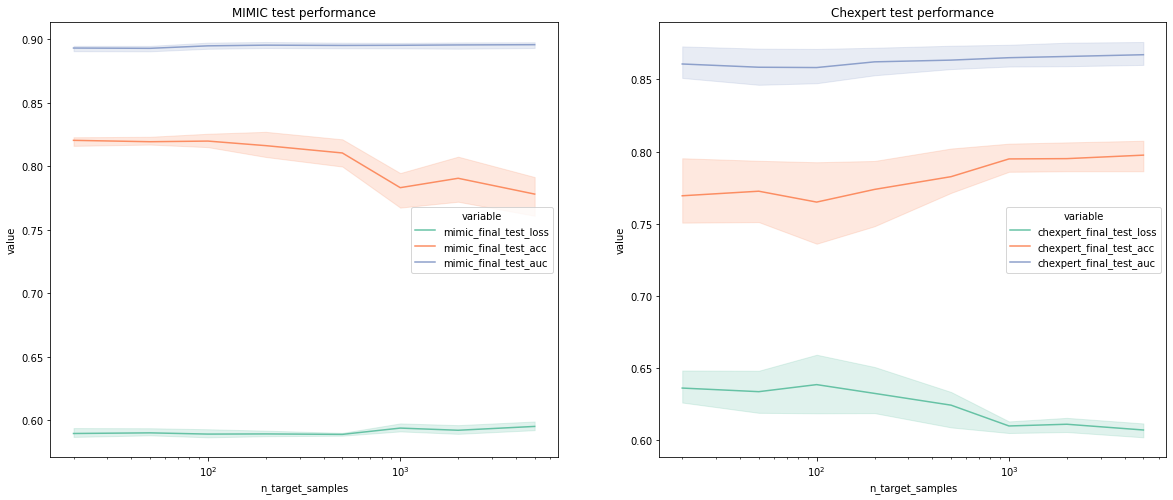

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
sns.lineplot(data=mimic_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[0])
ax[0].set_title('MIMIC test performance')
ax[0].set(xscale='log')
sns.lineplot(data=chex_meta, x='n_target_samples', y='value', hue='variable', palette='Set2', ax=ax[1])
ax[1].set_title('Chexpert test performance')
ax[1].set(xscale='log');

In [74]:
import os
import ast
import re
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [75]:
SHARED_DIR = '/shared/rsaas/nschiou2/'

DATA_DIR = os.path.join(SHARED_DIR, 'CXR', 'data')

REAL_MIMIC_TRAIN_PATH = os.path.join(DATA_DIR, 'train', 'mimic')
REAL_CHEXPERT_TRAIN_PATH = os.path.join(DATA_DIR, 'train', 'chexpert')
REAL_MIMIC_TEST_PATH = os.path.join(DATA_DIR, 'test', 'mimic')
REAL_CHEXPERT_TEST_PATH = os.path.join(DATA_DIR, 'test', 'chexpert')

RESULTS_DIR = os.path.join(SHARED_DIR, 'domain_adapt_cxr')

SSDA_RESULTS_DIR = os.path.join(RESULTS_DIR, 'ssda')

In [76]:
def summarize(path, fname):
    model_meta = pd.read_parquet(os.path.join(path, fname))
    def replace(x):
        try:
            return ast.literal_eval(x)
        except:
            return x
    for col in ['train_clf_loss', 'train_tgt_loss', 'valid_clf_loss', 'valid_acc']:
        try:
            model_meta[col] = model_meta[col].apply(replace)
        except:
            pass

    model_meta['epochs'] = model_meta['train_clf_loss'].apply(len)
    model_meta['best_valid_loss'] = model_meta['valid_clf_loss'].apply(min)

    return model_meta

In [77]:
model_meta = pd.DataFrame()

root_dir = os.path.join(SSDA_RESULTS_DIR, 'resnet50', '66_33_split', 'early_stop', 'resnet_orig')
    
for i in [20, 50, 100, 200, 500, 1000, 2000, 5000]:
    exp_dir = os.path.join(root_dir, f'ssda_s_20k_t_{i}')
    for f in os.listdir(exp_dir):
        if f.endswith('.parquet'):
            trial_results = summarize(exp_dir, f)
            _, iter_idx, _ = re.split('[_.]', f)
            trial_results.loc[:, 'iter_idx'] = iter_idx

            try:
                with open(os.path.join(exp_dir, f'args_{iter_idx}.json')) as arg_f:
                    args = json.load(arg_f)
            except OSError:
                print('No corresponding args.json file associated with trial!')

            for key in ['batch_size', 'method', 'lr', 'multi', 'T', 'lam', 'net', 'train_seed', 'data_sampler_seed', 'num_labeled']:
                trial_results.loc[:, key] = args[key]

            model_meta = model_meta.append(trial_results, ignore_index=True)
        

Analyze cross-validation results

In [78]:
cols = ['best_valid_loss', 'best_valid_acc', 'test_src_loss', 'test_src_acc', 'test_tgt_loss', 'test_tgt_acc', 'epochs']

In [79]:
model_meta.groupby('num_labeled').min(numeric_only=True)[cols]

,best_valid_loss,best_valid_acc,test_src_loss,test_src_acc,test_tgt_loss,test_tgt_acc,epochs
num_labeled,,,,,,,
20,-0.791215,78.750190,-0.855418,84.0500,-0.788687,76.986713,38001
50,-0.799216,79.538204,-0.855165,85.2250,-0.786673,78.027074,35001
100,-0.800938,79.381757,-0.856165,84.2375,-0.787890,77.500627,33001
200,-0.809025,79.752066,-0.857139,84.4000,-0.803196,78.415643,39001
500,-0.811296,80.186480,-0.857580,84.0000,-0.796005,77.964402,36001
1000,-0.813233,80.303030,-0.853072,84.8125,-0.804336,79.468538,32001
2000,-0.820110,80.505051,-0.856540,83.7750,-0.808320,79.242918,53001
5000,-0.824149,81.818182,-0.860386,85.3125,-0.815981,81.223364,43001


In [80]:
model_meta.groupby('num_labeled').mean()[cols]

,best_valid_loss,best_valid_acc,test_src_loss,test_src_acc,test_tgt_loss,test_tgt_acc,epochs
num_labeled,,,,,,,
20,-0.788546,79.018151,-0.849440,84.991667,-0.779439,77.897552,46521.333333
50,-0.796241,79.745810,-0.853822,85.416667,-0.783620,78.277764,42001.000000
100,-0.797115,79.721842,-0.850961,85.129167,-0.783384,78.327902,37667.666667
200,-0.803564,80.450974,-0.851620,85.233333,-0.792849,79.222027,47667.666667
500,-0.807201,80.782181,-0.848404,84.983333,-0.789527,78.921200,52334.333333
1000,-0.808010,80.893142,-0.849502,85.091667,-0.800064,80.070193,48542.333333
2000,-0.814621,81.526375,-0.849422,84.975000,-0.801203,80.145400,66334.333333
5000,-0.820495,82.154882,-0.857604,85.783333,-0.813604,81.369600,60001.000000


In [81]:
model_meta.groupby('num_labeled').std()[cols]

,best_valid_loss,best_valid_acc,test_src_loss,test_src_acc,test_tgt_loss,test_tgt_acc,epochs
num_labeled,,,,,,,
20,0.002447,0.246600,0.008220,0.821616,0.009701,0.884931,13900.620142
50,0.002867,0.346511,0.001385,0.166458,0.003144,0.244663,7000.000000
100,0.003643,0.350677,0.007282,0.791787,0.007230,0.716441,5686.240703
200,0.006374,0.613393,0.007875,0.734670,0.009204,0.959549,9018.499506
500,0.004799,0.532534,0.010233,0.935609,0.008326,0.851083,24090.108620
1000,0.005725,0.554556,0.003228,0.334555,0.005730,0.524804,16818.535172
2000,0.008142,0.888489,0.010478,1.045302,0.008430,0.817051,14640.127504
5000,0.003790,0.315781,0.003768,0.411615,0.002227,0.165499,15394.804318


In [82]:
model_meta.groupby('num_labeled').count()[cols]

,best_valid_loss,best_valid_acc,test_src_loss,test_src_acc,test_tgt_loss,test_tgt_acc,epochs
num_labeled,,,,,,,
20,3,3,3,3,3,3,3
50,3,3,3,3,3,3,3
100,3,3,3,3,3,3,3
200,3,3,3,3,3,3,3
500,3,3,3,3,3,3,3
1000,3,3,3,3,3,3,3
2000,3,3,3,3,3,3,3
5000,3,3,3,3,3,3,3


In [83]:
target_meta = model_meta.copy()
target_meta.rename({'num_labeled': 'n_target_samples', 'test_tgt_acc': 'mimic_best_test_acc'}, axis=1, inplace=True)
target_meta.loc[:, 'mimic_best_test_acc'] = target_meta.loc[:, 'mimic_best_test_acc'] / 100.

In [84]:
target_meta[['n_target_samples', 'mimic_best_test_acc']]

,n_target_samples,mimic_best_test_acc
0,20,0.779519
1,20,0.787541
2,20,0.769867
3,50,0.785159
4,50,0.782903
5,50,0.780271
6,100,0.787415
7,100,0.787415
8,100,0.775006
9,200,0.784156


In [64]:
target_meta = pd.DataFrame()

In [75]:
import_df = pd.DataFrame()

import_df.loc[:, 'n_target_samples'] = [0, 20, 50, 100, 200, 500, 1000, 2000, 5000]
import_df.loc[:, 'mimic_best_test_acc'] = [0.7197500467, 0.727375031, 0.722250044, 0.809750021, 0.820500016, 0.829000056, 0.833250046, 0.840500057, 0.840625048]

In [76]:
import_df

,n_target_samples,mimic_best_test_acc
0,0,0.719750
1,20,0.727375
2,50,0.722250
3,100,0.809750
4,200,0.820500
5,500,0.829000
6,1000,0.833250
7,2000,0.840500
8,5000,0.840625


In [77]:
target_meta = target_meta.append(import_df, ignore_index=True)

In [78]:
target_meta.shape

(27, 2)

In [79]:
target_meta.groupby('n_target_samples').mean()

,mimic_best_test_acc
n_target_samples,
0,0.719750
20,0.737958
50,0.743958
100,0.802208
200,0.815667
500,0.827792
1000,0.833500
2000,0.839167
5000,0.841375


In [134]:
plot_df = pd.DataFrame()

In [145]:
name = 'Finetune (all)'

In [146]:
temp = target_meta[['n_target_samples', 'chexpert_best_test_acc']].copy()
temp = temp.rename({'chexpert_best_test_acc': 'chexpert_test_acc'}, axis=1)
temp = pd.concat([source_meta[['n_target_samples', 'chexpert_test_acc']], temp], axis=0)
temp = temp.assign(approach=name)

In [147]:
temp

,n_target_samples,chexpert_test_acc,approach
0,0,0.712250,Finetune (all)
1,0,0.720625,Finetune (all)
2,0,0.713250,Finetune (all)
3,1000,0.831625,Finetune (all)
4,1000,0.824625,Finetune (all)
5,1000,0.822375,Finetune (all)
6,50,0.775500,Finetune (all)
7,50,0.785875,Finetune (all)
8,50,0.799875,Finetune (all)
9,500,0.821500,Finetune (all)


In [148]:
plot_df = plot_df.append(temp, ignore_index=True)

In [152]:
plot_df = plot_df.append(dann, ignore_index=True)

In [153]:
plot_df.shape

(108, 3)

In [154]:
plot_df.groupby('approach').count()

,n_target_samples,chexpert_test_acc
approach,,
DANN Finetune (all),27,27
DANN Finetune (clf),27,27
Finetune (all),27,27
Finetune (clf),27,27


In [155]:
# plot_df = plot_df.drop(['variable', 'value'], axis=1)

In [156]:
last_df = plot_df.melt(id_vars=['n_target_samples', 'chexpert_test_acc'], value_vars=['approach'])

In [157]:
sorter = ['Finetune (clf)', 'Finetune (all)', 'DANN Finetune (clf)', 'DANN Finetune (all)'] #, 'SSDA w/ MME']
last_df.value = last_df.value.astype("category")
last_df.value.cat.set_categories(sorter, inplace=True)
last_df.sort_values(['value'], inplace=True)
last_df

,n_target_samples,chexpert_test_acc,variable,value
0,0,0.712250,approach,Finetune (clf)
26,500,0.798750,approach,Finetune (clf)
25,500,0.766500,approach,Finetune (clf)
24,500,0.778375,approach,Finetune (clf)
23,20,0.780750,approach,Finetune (clf)
...,...,...,...,...
82,0,0.719750,approach,DANN Finetune (all)
81,5000,0.845500,approach,DANN Finetune (all)
106,2000,0.831000,approach,DANN Finetune (all)
93,50,0.826000,approach,DANN Finetune (all)


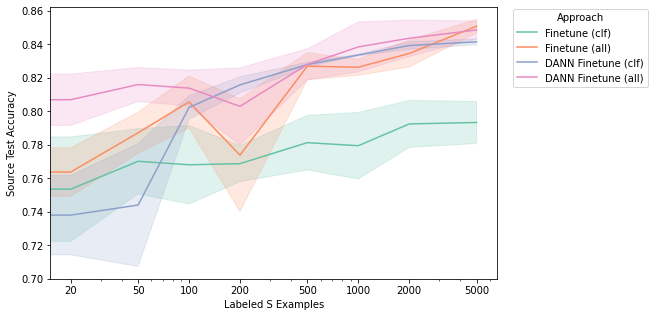

In [158]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
g = sns.lineplot(data=last_df, x='n_target_samples', y='chexpert_test_acc', hue='value', ax=ax, palette='Set2', ci='sd')
ax.set(xscale='log')
ax.set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.set_xticklabels([20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.set(xlabel='Labeled S Examples')
ax.set(ylabel='Source Test Accuracy')
ax.legend(title='Approach', loc='right', bbox_to_anchor=(1.35, 0.85))
plt.show()

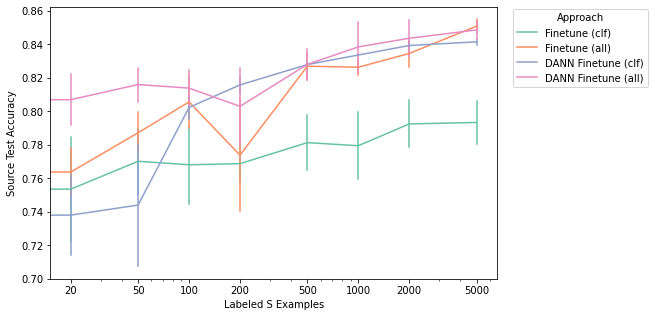

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.lineplot(data=last_df, x='n_target_samples', y='chexpert_test_acc', hue='value', ax=ax, palette='Set2', err_style='bars', ci='sd')
ax.set(xscale='log')
ax.set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.set_xticklabels([20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.set(xlabel='Labeled S Examples')
ax.set(ylabel='Source Test Accuracy')
ax.legend(title='Approach', loc='right', bbox_to_anchor=(1.35, 0.85));

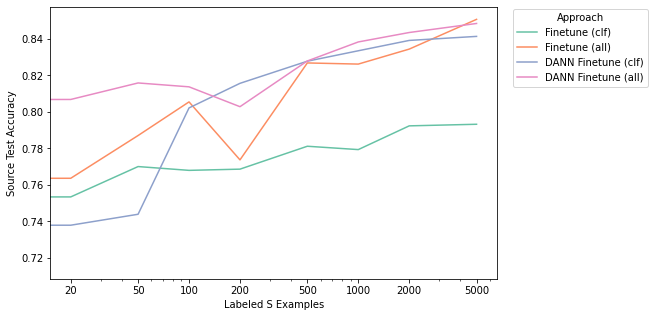

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.lineplot(data=last_df, x='n_target_samples', y='chexpert_test_acc', hue='value', ax=ax, palette='Set2', err_style='bars', ci=None)
ax.set(xscale='log')
ax.set_xticks([20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.set_xticklabels([20, 50, 100, 200, 500, 1000, 2000, 5000])
ax.set(xlabel='Labeled S Examples')
ax.set(ylabel='Source Test Accuracy')
ax.legend(title='Approach', loc='right', bbox_to_anchor=(1.35, 0.85));

In [93]:
last_df[last_df['value'].str.startswith('DANN')].to_parquet('reverse_DANN_expt_results.parquet', index=False)

In [94]:
dann = pd.read_parquet('reverse_DANN_expt_results.parquet')
dann = dann.rename({'value': 'approach'}, axis=1)
dann = dann.drop(['variable'], axis=1)

In [95]:
dann

,n_target_samples,mimic_test_acc,approach
0,20,0.765125,DANN Finetune (clf)
1,0,0.719750,DANN Finetune (clf)
2,5000,0.840125,DANN Finetune (clf)
3,2000,0.836500,DANN Finetune (clf)
4,200,0.815625,DANN Finetune (clf)
5,500,0.828125,DANN Finetune (clf)
6,100,0.801000,DANN Finetune (clf)
7,50,0.723375,DANN Finetune (clf)
8,50,0.786250,DANN Finetune (clf)
9,1000,0.833250,DANN Finetune (clf)


In [151]:
dann = dann.rename({'mimic_test_acc': 'chexpert_test_acc'}, axis=1)